In [1]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.9 MB/s eta 0:00:00


In [25]:
import pandas as pd, numpy as np
from pathlib import Path

MANIFEST = "seq_manifest.csv"
LABEL_COL = "amr_gene_family"
EPISODES  = 600
N, Q      = 5, 3
Ks        = [1,3,5]

df = pd.read_csv(MANIFEST, dtype=str)
df = df[df[LABEL_COL].notna() & (df[LABEL_COL]!="NA")].copy()

def make_splits(K, seed=42):
    np.random.seed(seed)

    counts = df[LABEL_COL].value_counts()
    labels = counts[counts >= (K + Q)].index.tolist()
    print(f"K={K}: usable classes={len(labels)}")

    out_root = Path(f"splits_{LABEL_COL}/K{K}")
    out_root.mkdir(parents=True, exist_ok=True)

    for epi in range(EPISODES):
        picked = np.random.choice(labels, size=min(N, len(labels)), replace=False)
        S, Qr = [], []
        for lab in picked:
            cand = df[df[LABEL_COL]==lab]
            idx = np.random.choice(cand.index, size=K+Q, replace=False)
            S.append(cand.loc[idx[:K], ["seq_id", LABEL_COL]])
            Qr.append(cand.loc[idx[K:], ["seq_id", LABEL_COL]])
        S = pd.concat(S)
        Qr = pd.concat(Qr)

        ep_dir = out_root/f"episode_{epi:04d}"
        ep_dir.mkdir(parents=True, exist_ok=True)
        S.to_csv(ep_dir/"support.csv", index=False)
        Qr.to_csv(ep_dir/"query.csv", index=False)

for K in Ks:
    make_splits(K)

print("Done generating few-shot episodes!")


K=1: usable classes=73
K=3: usable classes=43
K=5: usable classes=26
Done generating few-shot episodes!


Using device: cuda
Loaded encoder.
--- K=1 ---
NDARO few-shot: K=1  acc=0.942 ± 0.088
--- K=3 ---
NDARO few-shot: K=3  acc=0.955 ± 0.083
--- K=5 ---
NDARO few-shot: K=5  acc=0.968 ± 0.083

Running t-SNE on first 3 episodes (same as original)...


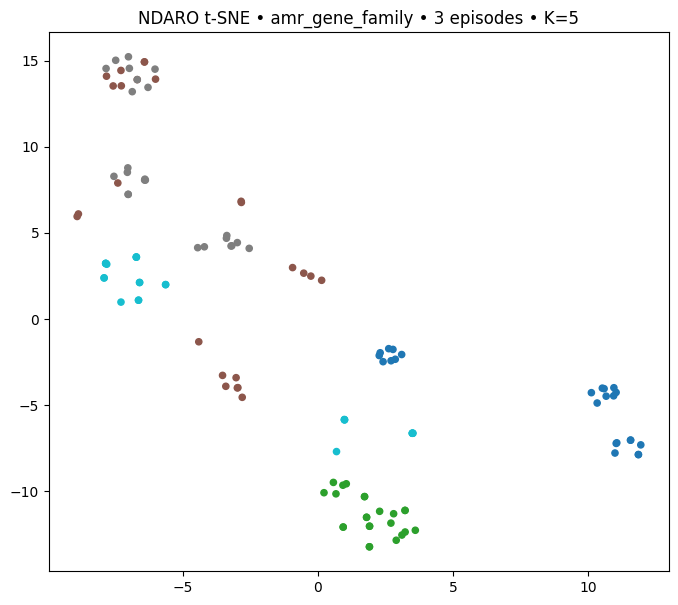

In [26]:
import os, json, numpy as np, pandas as pd, torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

MANIFEST     = "seq_manifest.csv"
SPLITS_ROOT  = "splits_amr_gene_family"
CHECKPOINT   = "best_metaoptnet_cnn.pt"
STOI_JSON    = "stoi.json"
NUM_MEAN     = "num_mean.npy"
NUM_STD      = "num_std.npy"
LABEL_COL    = "amr_gene_family"

KMER_K       = 5
MAX_LEN      = 512
N, Q         = 5, 3
K_VALUES     = [1,3,5]

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

manifest = pd.read_csv(MANIFEST, dtype=str)
manifest["gc_content"] = manifest["gc_content"].astype(float)
manifest["seq_len"]    = manifest["seq_len"].astype(float)
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

with open(STOI_JSON) as f:
    stoi = json.load(f)
PAD, UNK = "", ""
pad_id = stoi.get(PAD, 0)
unk_id = stoi.get(UNK, 1)

num_mean = np.load(NUM_MEAN)
num_std  = np.load(NUM_STD)

def kmers(seq, k=KMER_K):
    seq = seq.upper()
    L = len(seq)
    return [seq[i:i+k] for i in range(L-k+1)] if L >= k else []

def encode_seq(seq):
    toks = kmers(seq)
    if not toks:
        return [unk_id]
    return [stoi.get(tok, unk_id) for tok in toks]

def pad_ids(ids):
    out = np.full((MAX_LEN,), pad_id, dtype=np.int64)
    out[:min(len(ids), MAX_LEN)] = ids[:MAX_LEN]
    return out

class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len,
                 embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7),
                 use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32)
        )
        fused_in = conv_channels * len(kernel_sizes) * 2 + 32
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, 256)
        )
        self.log_temp = nn.Parameter(torch.zeros(1))

    def forward(self, tokens, nums):
        x = self.emb(tokens)
        x = self.emb_dropout(x).transpose(1, 2)
        pooled = []
        for conv in self.convs:
            h = conv(x)
            pooled += [
                F.adaptive_max_pool1d(h, 1).squeeze(-1),
                F.adaptive_avg_pool1d(h, 1).squeeze(-1)
            ]
        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        z      = self.proj(torch.cat([h_text, h_num], dim=1))
        return F.normalize(z, p=2, dim=1)

model = CNNSeqEncoder(vocab_size=len(stoi), pad_idx=pad_id, max_len=MAX_LEN).to(device)
model.load_state_dict(torch.load(CHECKPOINT, map_location=device), strict=True)
model.eval()
print("Loaded encoder.")

def ridge_head(s_z, s_y, q_z, l2=1e-3):
    C = int(s_y.max().item()) + 1
    Y = F.one_hot(s_y, num_classes=C).float()
    A = s_z.T @ s_z + l2 * torch.eye(s_z.shape[1], device=s_z.device)
    B = s_z.T @ Y
    W = torch.linalg.solve(A, B)
    return q_z @ W

@torch.no_grad()
def eval_episode(ep_dir):
    S = pd.read_csv(ep_dir/"support.csv")
    Q = pd.read_csv(ep_dir/"query.csv")

    labs = sorted(S[LABEL_COL].unique())
    lab2id = {l:i for i,l in enumerate(labs)}

    def make_batch(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            s = seq_by_id[r["seq_id"]]["sequence"]
            ids = pad_ids(encode_seq(s))
            toks.append(ids)
            nums.append([seq_by_id[r["seq_id"]]["gc_content"],
                         seq_by_id[r["seq_id"]]["seq_len"]])
            ys.append(lab2id[r[LABEL_COL]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys

    s_tok, s_num, s_y = make_batch(S)
    q_tok, q_num, q_y = make_batch(Q)

    s_z = model(s_tok, s_num)
    q_z = model(q_tok, q_num)
    logits = ridge_head(s_z, s_y, q_z)

    pred = logits.argmax(dim=1)
    return (pred == q_y).float().mean().item()

for K in K_VALUES:
    print(f"--- K={K} ---")
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:600]
    accs = [eval_episode(ep) for ep in ep_dirs]
    accs = np.array(accs)
    print(f"NDARO few-shot: K={K}  acc={accs.mean():.3f} ± {accs.std():.3f}")

print("\nRunning t-SNE on first 3 episodes (same as original)...")

EPISODES_TO_VIS = [0,1,2]
root = Path(SPLITS_ROOT)/"K5"
eps = sorted([p for p in root.iterdir() if p.is_dir()])
eps = [eps[i] for i in EPISODES_TO_VIS]

X = []
Y = []

for ep in eps:
    S = pd.read_csv(ep/"support.csv")
    Q = pd.read_csv(ep/"query.csv")
    labs = sorted(S[LABEL_COL].unique())
    lab2id = {l:i for i,l in enumerate(labs)}

    def make_emb(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            s = seq_by_id[r["seq_id"]]["sequence"]
            ids = pad_ids(encode_seq(s))
            toks.append(ids)
            nums.append([seq_by_id[r["seq_id"]]["gc_content"],
                         seq_by_id[r["seq_id"]]["seq_len"]])
            ys.append(lab2id[r[LABEL_COL]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = np.array(ys)
        with torch.no_grad():
            z = model(toks, nums).cpu().numpy()
        return z, ys

    s_z, s_y = make_emb(S)
    q_z, q_y = make_emb(Q)
    X.append(np.vstack([s_z, q_z]))
    Y.append(np.concatenate([s_y, q_y]))

X = np.vstack(X)
Y = np.concatenate(Y)

tsne = TSNE(n_components=2, perplexity=20, random_state=42)
X2 = tsne.fit_transform(X)

plt.figure(figsize=(8,7))
plt.scatter(X2[:,0], X2[:,1], c=Y, cmap="tab10", s=20)
plt.title("NDARO t-SNE • amr_gene_family • 3 episodes • K=5")
plt.show()
